In [1]:
## import required packages/functions
import os
import numpy as np
import matplotlib.pyplot as plt
from sympy import Point, Line, N
import napari
from scipy.ndimage import rotate
from skimage.transform import rescale
%matplotlib inline

In [17]:
## these points were validated by hand
a = np.asarray([[ 76,142,795], [ 87,123,877], [105,330,962], [104,212,983]]) # from light-sheet bead data
#np.save('light-sheet_registration_curated_bead_coordinates', a)
b = np.asarray([[103,261,370], [116,243,451], [136,450,538], [131,333,560]]) # from label-free bead data
#np.save('label-free_registration_curated_bead_coordinates', b)

In [3]:
# define additional required functions

def measure_z_axis_rotation_angle(a,b):
    
    # remove z-axis component of bead point arrays
    a_xy = a[:,1:]
    b_xy = b[:,1:]

    # measure angles between corresponding point pairs of a & b (measurements in radians)
    angles = np.zeros((a_xy.shape[0],1))
    for i in range(a.shape[0]):
    
        a_pt = Point(a_xy[i,...])
        b_pt = Point(b_xy[i,...])

        a_line = Line(Point(0,0), a_pt)
        b_line = Line(Point(0,0), b_pt)

        angles[i,0] = float((N(a_line.angle_between(b_line))))

    return angles

In [4]:
def rotate_around_z_axis(image_coordinates, angle):

    # this is usually the x_rot_mat, but axes swap in python requires reordering
    z_rot_mat = np.array([[1,             0,              0],
                          [0, np.cos(angle), -np.sin(angle)],
                          [0, np.sin(angle),  np.cos(angle)]])

    rotated_coordinates =  image_coordinates @ z_rot_mat # use @ for matrix multiplication
    
    return(rotated_coordinates)

In [5]:
def measure_y_axis_rotation_angle(a,b):

    # remove y-axis component of bead point arrays
    a_zx = np.delete(a, 1, 1)
    b_zx = np.delete(b, 1, 1)
    
    # measure angles between corresponding point pairs of a & b
    angles = np.zeros((a_zx.shape[0],1))
    for i in range(4):
    
        a_pt = Point(a_zx[i,...])
        b_pt = Point(b_zx[i,...])

        a_line = Line(Point(0,0), a_pt)
        b_line = Line(Point(0,0), b_pt)

        angles[i,0] = float((N(a_line.angle_between(b_line))))
    
    return angles

In [6]:
def rotate_around_y_axis(image_coordinates, angle):

    y_rot_mat = np.array([[np.cos(angle), 0, -np.sin(angle)],
                          [            0, 1,              0],
                          [np.sin(angle), 0,  np.cos(angle)]])

    rotated_coordinates =  image_coordinates @ y_rot_mat

    #print(a,b)

    return(rotated_coordinates)

In [7]:
def measure_x_axis_rotation_angle(a,b):

    # remove z-axis component of bead point arrays
    a_zy = a[:,:-1]
    b_zy = b[:,:-1]

    # measure angles between corresponding point pairs of a & b
    angles = np.zeros((a_zy.shape[0],1))
    for i in range(4):
    
        a_pt = Point(a_zy[i,...])
        b_pt = Point(b_zy[i,...])

        a_line = Line(Point(0,0), a_pt)
        b_line = Line(Point(0,0), b_pt)

        angles[i,0] = float((N(a_line.angle_between(b_line))))
    
    return angles

In [8]:
def rotate_around_x_axis(image_coordinates, angle):

    # this is usually the z_rot_mat, but axes swap in python requires reordering
    x_rot_mat = np.array([[np.cos(angle), -np.sin(angle), 0],
                          [np.sin(angle),  np.cos(angle), 0],
                          [            0,              0, 1]])

    rotated_coordinates = image_coordinates @ x_rot_mat

    return rotated_coordinates

In [9]:
#### ordered rotation of ICP matched bead reference coordinate sets
## start with z rotation
z_rotation_angle = np.mean(measure_z_axis_rotation_angle(a,b))
z_rotation = rotate_around_z_axis(a, z_rotation_angle)
print('rotate around z-axis by ', z_rotation_angle, 'radians yields -->')
print(z_rotation)

# feed result of z rotation into y rotation
y_rotation_angle = np.mean(measure_y_axis_rotation_angle(a,b))
y_rotation = rotate_around_y_axis(z_rotation, y_rotation_angle)
print('rotate around y-axis by ', y_rotation_angle, 'radians yields -->')
print(y_rotation)

# feed compounded result of z,y rotation into x rotation
x_rotation_angle = np.mean(measure_x_axis_rotation_angle(a,b))
x_rotation = rotate_around_x_axis(y_rotation, x_rotation_angle)
print('rotate around x-axis by ', x_rotation_angle, 'radians yields -->')
print(x_rotation)

## find translation vector after rotation angles & matrices have been applied. result should yield b reference array
translation_by_point = x_rotation-b
print('translate zyx-ordered rotation result by ', translation_by_point, 'yields-->')
print(x_rotation-translation_by_point)

## take mean of translation by point for downstream use
translation_vector = np.mean(translation_by_point, axis = 0)
print('mean translation for full fovs:', translation_vector)

rotate around z-axis by  0.37065526984732966 radians yields --> [[ 76.         420.32669977 689.57556907]
 [ 87.         432.31954115 772.88926396]
 [105.         656.05144426 777.13609007]
 [104.         553.67155375 839.45268513]]
rotate around y-axis by  0.14808531345903012 radians yields --> [[176.9114117  420.32669977 670.81503998]
 [200.08351289 432.31954115 751.59390778]
 [218.51310653 656.05144426 753.13844993]
 [226.71853278 553.67155375 814.92055899]]
rotate around x-axis by  0.09540490328532794 radians yields --> [[216.14731155 401.56260016 670.81503998]
 [240.35647629 411.29352304 751.59390778]
 [280.01501399 632.25237618 753.13844993]
 [278.43039249 529.55641727 814.92055899]]
translate zyx-ordered rotation result by  [[113.14731155 140.56260016 300.81503998]
 [124.35647629 168.29352304 300.59390778]
 [144.01501399 182.25237618 215.13844993]
 [147.43039249 196.55641727 254.92055899]] yields [[103. 261. 370.]
 [116. 243. 451.]
 [136. 450. 538.]
 [131. 333. 560.]]
[132.23729

In [10]:
# test this result on neuromast dataset

ls_resolution = (0.174, 0.116, 0.116)
lf_resolution = (0.174,0.1494,0.1494)

ls_img = np.load('neuromast_light-sheet_timepoint_start.npy')[1,...]
lf_img = np.squeeze(np.load('neuromast_label-free_timepoint_start.npy'))

ls_rot_neg90 = rotate(ls_img, -90, axes=(1,2))
ls_rotated_rescaled = rescale(ls_rot_neg90, np.asarray(ls_resolution)/np.asarray(lf_resolution))

In [11]:
## flatten image to be registered into 2D position and value arrays
ls_coordinates = np.asarray(np.where(ls_rotated_rescaled)).T
ls_values = np.ndarray.flatten(ls_rotated_rescaled)

#print(ls_coordinates.shape[0]==ls_values.shape[0])

In [12]:
## z,y,x ordered rotations on neuromast data
z_rotated_coordinates = rotate_around_z_axis(ls_coordinates, z_rotation_angle)
zy_rotated_coordinates = rotate_around_y_axis(z_rotated_coordinates, y_rotation_angle)
zyx_rotated_coordinates = rotate_around_x_axis(zy_rotated_coordinates, x_rotation_angle)

## translation after ordered rotation
zyx_rotated_coordinates_translation = zyx_rotated_coordinates - translation_vector

In [13]:
## create new array for registered voxels within label-free field of view
z_lf_shape_limit, y_lf_shape_limit, x_lf_shape_limit = lf_img.shape

ls_registered = np.zeros_like(lf_img)
counter=0
for i in range(ls_coordinates.shape[0]):
    iz, iy, ix = zyx_rotated_coordinates_translation[i,...]
    iz, iy, ix = (int(iz), int(iy), int(ix))
    #print(iz,iy,ix)
    if (iz>=0 and iz<z_lf_shape_limit) and (iy>=0 and iy<y_lf_shape_limit) and (ix>=0 and ix<x_lf_shape_limit):
        ls_registered[iz,iy,ix] = ls_values[i]
    else:
        continue

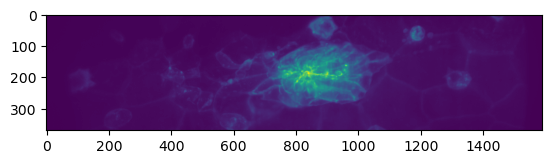

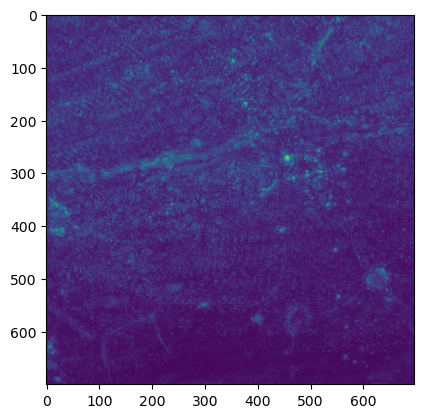

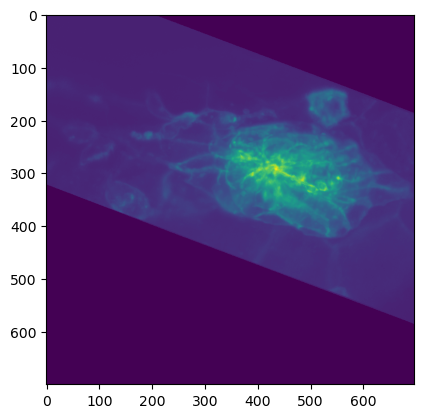

In [14]:
## plot max projections for quick visual inspection

plt.imshow(ls_rotated_rescaled.max(axis=0))
plt.show()

plt.imshow(lf_img.max(axis=0))
plt.show()

plt.imshow(ls_registered.max(axis=0))
plt.show()

In [15]:
## push to napari for further visual inspection

viewer = napari.Viewer()

#viewer.add_image(ls_rotated_rescaled, name='light-sheet_rotated_rescaled')
viewer.add_image(lf_img, name='label-free_img')
viewer.add_image(ls_registered, name='light-sheet_registered')

<Image layer 'light-sheet_registered' at 0x591ceaa20>

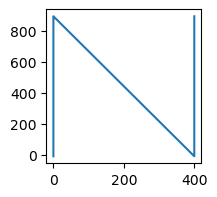

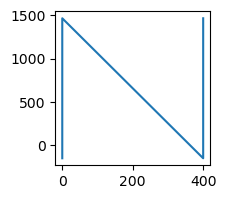

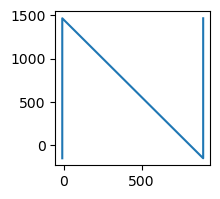

In [16]:
## plot corner vertices of transformed-translated data to make sure no strange shear has been introduced
## each plot should look like an 'N'

rotated_bbox_vertices_zy = np.asarray([(zyx_rotated_coordinates[:,0].min(),zyx_rotated_coordinates[:,1].min()),
                                       (zyx_rotated_coordinates[:,0].min(),zyx_rotated_coordinates[:,1].max()),
                                       (zyx_rotated_coordinates[:,0].max(),zyx_rotated_coordinates[:,1].min()),
                                       (zyx_rotated_coordinates[:,0].max(),zyx_rotated_coordinates[:,1].max())])

plt.figure(figsize=(2,2))
plt.plot(rotated_bbox_vertices_zy[:,0], rotated_bbox_vertices_zy[:,1])
plt.show()

rotated_bbox_vertices_zx = np.asarray([(zyx_rotated_coordinates[:,0].min(),zyx_rotated_coordinates[:,2].min()),
                                       (zyx_rotated_coordinates[:,0].min(),zyx_rotated_coordinates[:,2].max()),
                                       (zyx_rotated_coordinates[:,0].max(),zyx_rotated_coordinates[:,2].min()),
                                       (zyx_rotated_coordinates[:,0].max(),zyx_rotated_coordinates[:,2].max())])

plt.figure(figsize=(2,2))
plt.plot(rotated_bbox_vertices_zx[:,0], rotated_bbox_vertices_zx[:,1])
plt.show()

rotated_bbox_vertices_yx = np.asarray([(zyx_rotated_coordinates[:,1].min(),zyx_rotated_coordinates[:,2].min()),
                                       (zyx_rotated_coordinates[:,1].min(),zyx_rotated_coordinates[:,2].max()),
                                       (zyx_rotated_coordinates[:,1].max(),zyx_rotated_coordinates[:,2].min()),
                                       (zyx_rotated_coordinates[:,1].max(),zyx_rotated_coordinates[:,2].max())])

plt.figure(figsize=(2,2))
plt.plot(rotated_bbox_vertices_yx[:,0], rotated_bbox_vertices_yx[:,1])
plt.show()